# Dialect prediction using Auto-Encoder 

In [ ]:
# Step 1 - Trained Neural Network Autoencoder-Decoder Model on a vocalubry of 300 words
# Step 2 - Used the latent features of the Encoder for the Label prediction
# Step 3 - Integrated the Cost variation across label in the form of label class size/probability
#          (Cost is inversly proportion to label class probability)
# Step 4 - Saved the model and other attributes in a functional object
# Step 5 - Used the saved model and object for the label prediction

## Load Required Library 

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 7.6MB/s 


In [ ]:
!pip install tensorflow-probability

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import string
import random
import math
import pickle


## Paramer Declaration 

In [ ]:
latent_dim = 64 #Number of Nodes in Hidden layes
train_size = 10000 #Size of training vocablry 
v_size = 100 #Size of feature vector 
cost = [890,835,910,950,1300,850,500,750,2200,1100,3450,600,1850,900,1200] #Cost for each label
trade_factor = 0.5 #Factor to control the trade off between uniformatiy in labels probability vs the cost-effective label selection

# Feature Engineering 

## Training Data Load 

In [ ]:
# The trainin dataset has been downloaded form - https://norvig.com/ngrams/
words = pd.read_csv("./enable2.csv") #Opensource data corpus
words = list(words['aa'])
random.shuffle(words)

## Custom Data Vectorisation

In [ ]:
# Creating the list with all possible characters in english language
letters = list(string.ascii_letters)
punc = list(string.punctuation)
space = [' ','  ','   ']
letters.extend(punc)
letters.extend(space)
random.shuffle(letters)

In [ ]:
def word_to_vector(words):
  # Creating features out of the word based on the list of characters built in previous step
  features = list()
  for word in words:
      feature = ([0]*v_size)
      for i in range(len(word)):
          w = word[i]
          feature[i] = letters.index(w)
      features.append(feature)
  return features

vector_words = word_to_vector(words)

In [ ]:
# Splitting the vocab into training and test datasets
x_train = np.array(vector_words[:train_size])
x_train.shape

(10000, 100)

## Unsupervised

In [ ]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric

# ss_size = len(x_train)

# small subset to test
# x = x_train[:ss_size]
# ss_test = x_test[:ss_size]
# print(x.shape)
# mh_distance = DistanceMetric.get_metric('cosine')

# declare the model
kmedoids = KMedoids(n_clusters = 15, metric='cosine')
y_class = kmedoids.fit_predict(x_train)


([<matplotlib.axis.XTick at 0x7f16ab64a310>,
 <a list of 15 Text major ticklabel objects>)

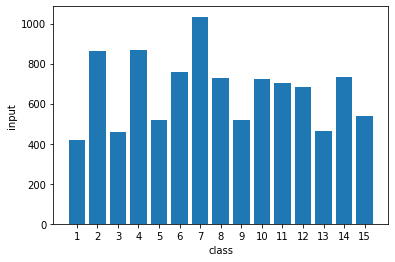

In [ ]:
# classes = np.argmax(pred, axis=1)
y, x = np.histogram(y_class, bins=np.arange(16))
x = x[1:]
plt.bar(x, y)
plt.ylabel('input')
plt.xlabel('class')
plt.xticks(np.arange(1, 16, step=1))


## Model 

### Loss 1

In [ ]:
# we don't have a y_true in unsupervised
def cost_loss_fn(y_true, y_pred):
  # cost of chosing a class
  cost = tf.constant([890,835,910,950,1300,850,500,750,2200,1100,3450,600,1850,900,1200],dtype=tf.float32)
  ret = tf.tensordot(y_pred, cost, axes=1)
  # print('ret shape', ret)
  return tf.reduce_mean(ret)

In [ ]:
def train_nn_with_custom_loss_function(custom_loss_function, nn, lr, batch_size, nb_epochs, save_to_folder=None, plot_loss=True):
  """
    Train a neural net with custom loss function, plots the loss
    and returns the history (output of nn)

    Args:
      custom_loss_function (function): One of the customly developed loss
          functions
  """
  # reset session
  tf.keras.backend.clear_session()
  # It's  important to use run_eagerly=True in this example because the custom loss 
  # function converts tensors to numpy arrays which requires to be on eager mode
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  nn.compile(optimizer=opt, loss=custom_loss_function, run_eagerly=True)
  # nn.build(input_shape=(100,))
  nn.summary()
  history = nn.fit(x_train, x_train,
                epochs=nb_epochs, batch_size = batch_size, verbose=1,
       shuffle=True)
  
  if save_to_folder is not None:
    nn.save(save_to_folder)

  plt.plot(history.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # plt.set_xticks(np.arange(len(history.history['loss'])))
  plt.show()

  pred = nn.predict(x_train)
  classes = np.argmax(pred, axis=1)
  y, x = np.histogram(classes, bins=np.arange(16))
  x = x[1:]
  plt.bar(x, y)
  plt.ylabel('input')
  plt.xlabel('class')
  plt.xticks(np.arange(1, 16, step=1))

  plt.show()
  return y

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 14,863
Trainable params: 14,863
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
313/313 [==============================] - 4s 13ms/step - loss: 742.9719
Epoch 2/5
313/313 [==============================] - 4s 13ms/step - loss: 622.7339
Epoch 3/5
313/313 [==============================] - 4s 13ms/step - loss: 558.8900
E

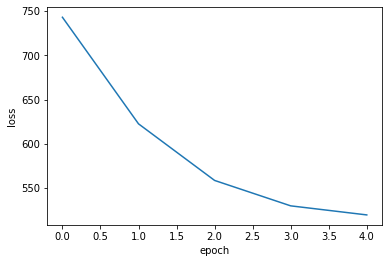

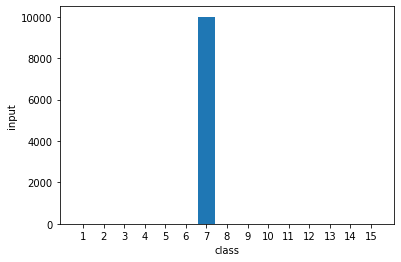

In [ ]:
# optimal solution is reached in this case which is the cost 500
base_nn = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(15, activation='softmax')
  ])
y_cost1 = train_nn_with_custom_loss_function(cost_loss_fn, base_nn, 0.00001, 32, 5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                495       
Total params: 9,039
Trainable params: 9,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 2s 14ms/step - loss: 849.9276
Epoch 2/5
157/157 [================

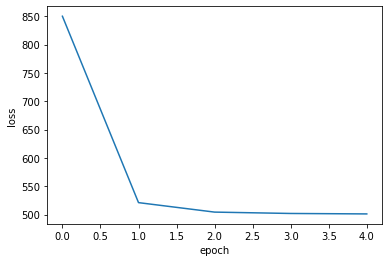

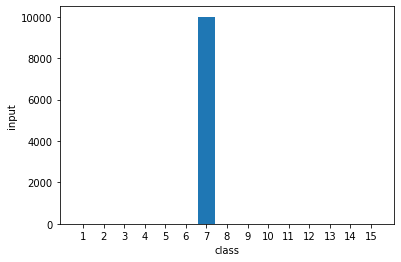

In [ ]:
# second neural net architecture finds a suboptimal solution that's 600
nn_2 = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(15, activation='softmax')
  ])
y_cost2 = train_nn_with_custom_loss_function(cost_loss_fn, nn_2, 0.0001, 64, 5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                255       
Total params: 9,327
Trainable params: 9,327
Non-trainable params: 0
______________________________________________________

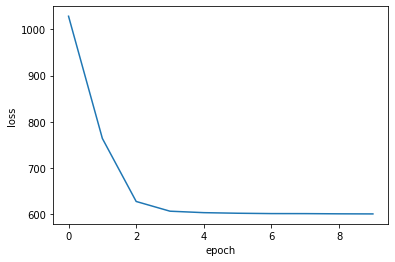

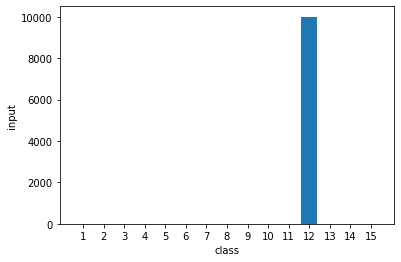

In [ ]:
# 3rd neural net architecture
nn_3 = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(15, activation='softmax')
  ])
y_cost3 = train_nn_with_custom_loss_function(cost_loss_fn, nn_3, 0.0001, 128, 10)

## Loss 2

In [ ]:
# we don't have a y_true in unsupervised 
# the entropy loss maximize the entropy for a uniform distribution
def entropy_loss_fn(y_true, y_pred):
  y_pred = tf.reduce_mean(y_pred, axis=0)
  ret = tf.tensordot(y_pred, tf.math.log(y_pred), axes=1)
  return ret

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 14,863
Trainable params: 14,863
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
313/313 [==============================] - 4s 13ms/step - loss: -1.6040
Epoch 2/5
313/313 [==============================] - 4s 14ms/step - loss: -2.0155
Epoch 3/5
313/313 [==============================] - 4s 13ms/step - loss: -2.1929
Epoc

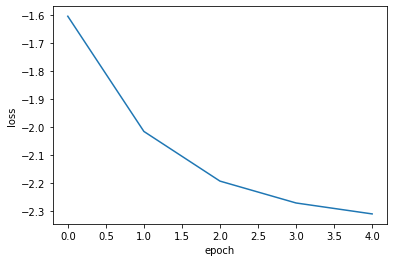

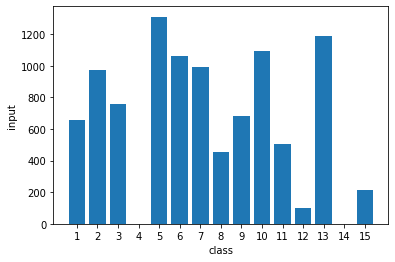

In [ ]:
# first set of hyperparams
base_nn = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(15, activation='softmax')
  ])
y_entropy1 = train_nn_with_custom_loss_function(entropy_loss_fn, base_nn, 0.00001, 32, 5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                495       
Total params: 9,039
Trainable params: 9,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 3s 16ms/step - loss: -1.6853
Epoch 2/5
157/157 [===================

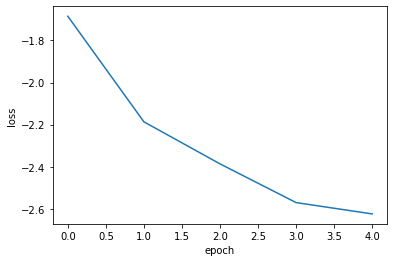

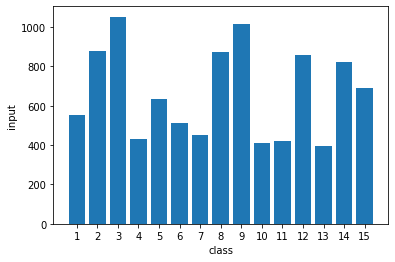

In [ ]:
# 2nd set of hyperparams
nn_2 = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(15, activation='softmax')
  ])
y_entropy2 = train_nn_with_custom_loss_function(entropy_loss_fn, nn_2, 0.0001, 64, 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 15)                255       
Total params: 9,327
Trainable params: 9,327
Non-trainable params: 0
____________________________________________________

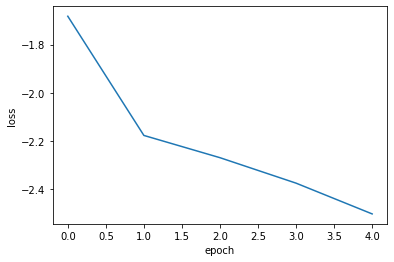

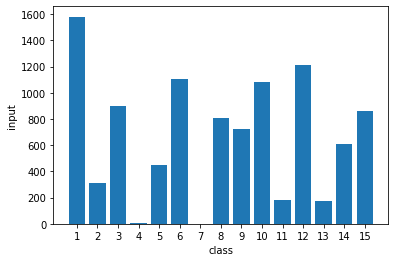

In [ ]:
# 3rd set of hyperparams
nn_3 = tf.keras.Sequential([
  layers.Flatten(input_shape=(100,)),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(15, activation='softmax')
  ])
y_entropy3 = train_nn_with_custom_loss_function(entropy_loss_fn, nn_3, 0.0001, 128, 5)

In [ ]:
test_words = ['get abcde.txt', 'get abcdf.txt', 'get aaaaaa.txt', 'get zzzzzz.txt', 'get fffffff.txt']
def print_predicted(word, nn):
  word_vector = word_to_vector(word)
  # print(word_vector)
  pred = nn.predict(word_vector)
  # print(pred)
  predicted_class = np.argmax(pred, axis=1)
  # print(predicted_class)
  print('Class of word \"%s\" is %s' % (word[0], predicted_class[0]))

# print(test_words[0])
for i in range(len(test_words)):
  print_predicted([test_words[i]], nn_entropy)

15
15


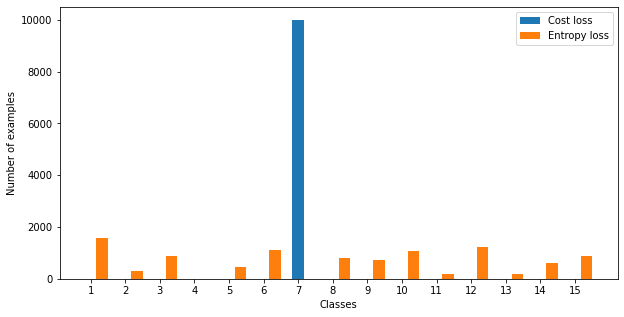

In [ ]:
def plot_combined(y1, y2, y1_name, y2_name):
  # Numbers of pairs of bars you want
  N = 15

  # Data on X-axis

  # Specify the values of blue bars (height)
  blue_bar = y1
  # Specify the values of orange bars (height)
  orange_bar = y2

  # Position of bars on x-axis
  ind = list(range(1, 16))
  print(len(ind))
  print(len(blue_bar))
  # Figure size
  plt.figure(figsize=(10,5))

  # Width of a bar 
  width = np.min(np.diff(ind))/3     

  # Plotting
  plt.bar(ind, blue_bar , width, label=y1_name)
  plt.bar(ind + width, orange_bar, width, label=y2_name)

  plt.xlabel('Classes')
  plt.ylabel('Number of examples')
  # plt.title('Here goes title of the plot')

  # xticks()
  # First argument - A list of positions at which ticks should be placed
  # Second argument -  A list of labels to place at the given locations
  plt.xticks(np.arange(1, 16, step=1))

  # Finding the best position for legends and putting it
  plt.legend(loc='best')
  plt.show()

plot_combined(y_cost1, y_entropy3, "Cost loss", "Entropy loss")

## Loss 3


In [ ]:
from scipy.spatial import distance

# we don't have a y_true in unsupervised
def distance_loss_fn(y_true, y_pred):
  # calculate the centroid of every cluster
  pred = tf.argmax(y_pred, axis=1).numpy()
  # centroids coordinates
  centroids = np.zeros((15, 100), dtype=float)
  # centroids frequency
  centroids_f = np.zeros(15)
  # points has the coordinates of the space of the points to cluster
  points = y_true.numpy()
  # iterate on points
  for idx in range(points.shape[0]):
    # sum point to calculate centroid later
    centroids[pred[idx]] += points[idx]
    centroids_f[pred[idx]] += 1
  # average over all points to calculate centroid
  for idx in range(len(centroids)):
    if centroids_f[idx] == 0:
      continue
    centroids[idx] /= centroids_f[idx]
  # sum over the distance between each point and the centroid to calculate the loss to minimize
  loss = 0
  for idx in range(len(points)):
    # add the distance between each coordinate and the centroid of the predicted class
    # tfa.metrics.hamming.hamming_loss_fn(y, output, threshold=0.5, mode='multilabel')
    # loss += tf.reduce_sum(centroids[pred[idx]] - points[idx])
    loss += distance.hamming(centroids[pred[idx]], points[idx])
    # loss += tfa.metrics.hamming.hamming_loss_fn(centroids[pred[idx]], 
    #                                             points[idx],
    #                                             threshold=0.5,
    #                                             mode='multilabel')
    # print('d ', distance.hamming(centroids[pred[idx]], points[idx]))
  l = tf.reduce_sum(y_pred)
  # print(loss)
  ret = tf.constant(loss, dtype=tf.float32)
  return ret

## Training using kmedoids clustering algorithm

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7MB 6.6MB/s 
     |████████████████████████████████| 22.3MB 124kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


([<matplotlib.axis.XTick at 0x7ff798c14fd0>,
 <a list of 15 Text major ticklabel objects>)

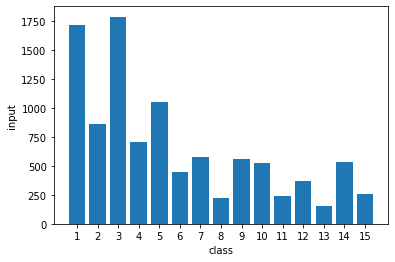

In [ ]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric

# declare the model
kmedoids = KMedoids(n_clusters = 15, metric='hamming')
# train the model and get the prediction
y_class = kmedoids.fit_predict(x_train)

# plotting
# classes = np.argmax(pred, axis=1)
y, x = np.histogram(y_class, bins=np.arange(16))
x = x[1:]
plt.bar(x, y)
plt.ylabel('input')
plt.xlabel('class')
plt.xticks(np.arange(1, 16, step=1))


## Merged loss: Loss1 + Loss2 + Loss3

In [ ]:
def merged_loss_fn(y_true, y_pred):
  l1 = cost_loss_fn(y_true, y_pred) + 0.0001
  l2 = entropy_loss_fn(y_true, y_pred) + 0.0001
  l3 = distance_loss_fn(y_true, y_pred) + 0.0001
  # print("%f %f %f\n" % (l1, l2, l3))
  return l1 + l2 + l3

In [ ]:
nn = train_nn_with_custom_loss_function(merged_loss_fn)

In [ ]:
pred = nn.predict(x_train)
pred